In [2]:
import os
import sys

sys.path.append("../python")
 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from data import Dataloader
from models import RandomExampleModel, TwoClustersMIP, HeuristicModel
import metrics

In [4]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()


In [4]:
Y.shape


(2000, 4)

In [5]:
# MIP Model 
model = TwoClustersMIP(n_clusters=2, n_pieces=5) # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, First formulation 
# model.fit_beta(X, Y) # Training of the model, second formulation 

# Heuristic Model 
# hyper_params = {'positive_mutation':0.8, 'negative_mutation':0.8, 'instances_limit':1000}
# model = HeuristicModel(n_clusters=4, n_features=X.shape[1], n_instances=X.shape[0], n_pieces=5, n_iter=100, hyper_params=hyper_params)
# model.fit(X, Y)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-11
Fitting the UTA models using the errors formulation
##########
Training started
minimum objective function x:  0.0


In [6]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[ 0.13650581 -0.01491436]
 [ 0.09746541 -0.39102323]
 [ 0.08297295 -0.47654669]
 [-0.01653087  0.27247264]
 [ 0.07674185 -0.00568638]]


In [7]:
# Or we can directly use the predict_preference method:

pref = model.predict_preference(X, Y)
print(pref[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


In [8]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 1.0


In [9]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 1.0
Percentage of explained preferences for all samples: 1.0


In [10]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 1 0]


In [11]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [12]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 1.0
Cluster intersection for all samples: 0.9930210105052526
Cluster intersection for all samples: 0.9930210105052526


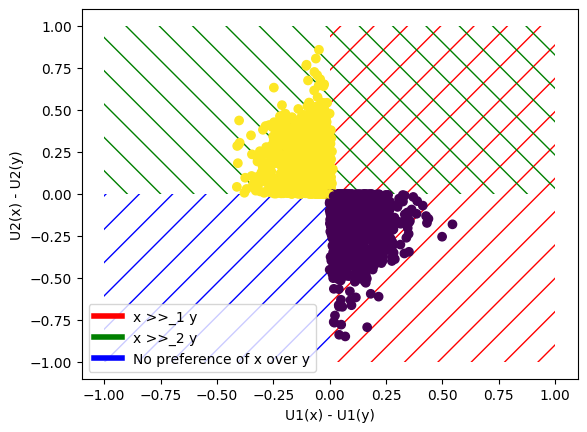

In [13]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [14]:
# # This cell should work when you have completed the TwoClustersMIP model
# from models import TwoClustersMIP

# parameters = {"n_pieces": 5, "n_clusters": 2} # Can be completed
# model = TwoClustersMIP(**parameters)
# model.fit(X, Y)

# # Uncomment once your model is working
# # print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# # print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

In [15]:
model.predict_utility(X)

array([[0.9723247 , 0.97774516],
       [0.8546031 , 0.60363097],
       [0.78979109, 0.50972561],
       ...,
       [0.77375562, 0.99426852],
       [0.76072222, 0.98326445],
       [0.67907227, 0.98624451]])

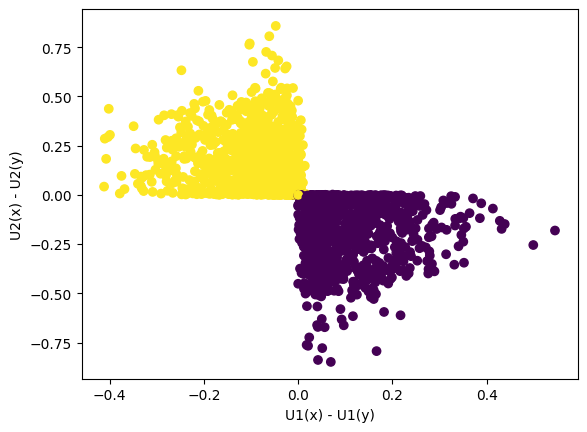

In [16]:
# As an example here are the results obtained with:
 # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()



Set parameter Username


Academic license - for non-commercial use only - expires 2024-12-11
Fitting model with sample size: 50
Fitting the UTA models using the errors formulation
##########
Training started
minimum objective function x:  0.0
Fitting model with sample size: 100
Fitting the UTA models using the errors formulation
##########
Training started
minimum objective function x:  0.0
Fitting model with sample size: 150
Fitting the UTA models using the errors formulation
##########
Training started
minimum objective function x:  0.0
Fitting model with sample size: 200
Fitting the UTA models using the errors formulation
##########
Training started
minimum objective function x:  0.0
Fitting model with sample size: 250
Fitting the UTA models using the errors formulation
##########
Training started
minimum objective function x:  0.0
Fitting model with sample size: 300
Fitting the UTA models using the errors formulation
##########
Training started
minimum objective function x:  0.0
Fitting model with sample s

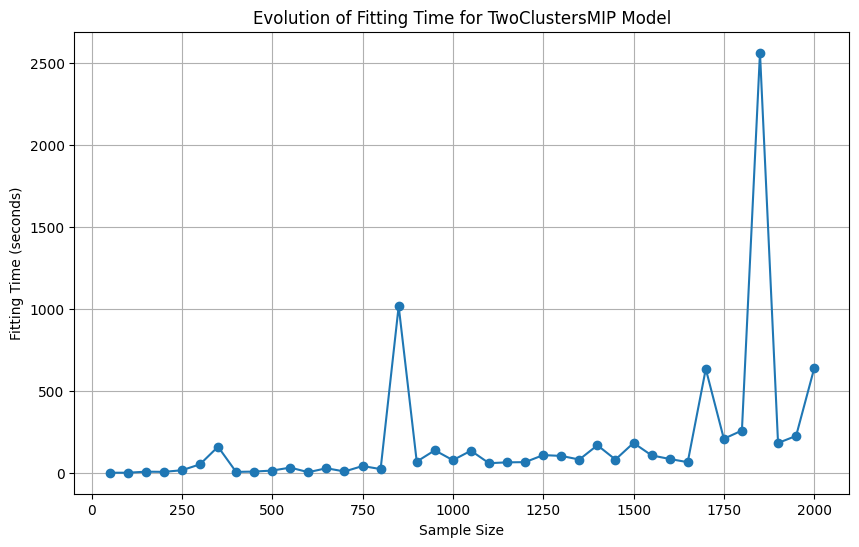

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
# Function to measure fitting time for TwoClustersMIP model
def measure_fitting_time(model, X, Y):
    start_time = time.time()
    model.fit(X, Y)
    end_time = time.time()
    return end_time - start_time

# Generate sample sizes from 50 to 2000 in increments of 50
sample_sizes = np.arange(50, 2001, 50)

# Initialize an empty list to store fitting times
fitting_times = []

# Iterate over each sample size
for size in sample_sizes:
    # Select the first `size` samples
    X_ = X[:size]
    Y_ = Y[:size]
    
    # Instantiate the TwoClustersMIP model
    model = TwoClustersMIP(n_clusters=2, n_pieces=5)
    print("Fitting model with sample size:", size)
    # Measure the fitting time for the TwoClustersMIP model
    fitting_time = measure_fitting_time(model, X_, Y_)
    
    # Record the fitting time
    fitting_times.append(fitting_time)

# Plot the evolution of fitting time with sample size
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, fitting_times, marker='o', linestyle='-')
plt.title('Evolution of Fitting Time for TwoClustersMIP Model')
plt.xlabel('Sample Size')
plt.ylabel('Fitting Time (seconds)')
plt.grid(True)
plt.show()

Your second assignement will be to find another model that will work well with larger data instances.